<a href="https://colab.research.google.com/github/Dhanraj7573/Python-Projects/blob/main/Risk_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install requests matplotlib



=== Risk Dashboard (Day 1) ===
Symbol: aapl.us
Observations (returns): 10433
Total return (period): 277842.04%
Latest 20D ann. volatility (log returns): 24.88%
Max drawdown: -82.24%
Max drawdown duration: 2129 days

Worst 5 daily returns:
  2000-09-29 : -51.85%
  1987-10-19 : -24.38%
  1993-07-16 : -23.08%
  1987-10-26 : -21.14%
  2008-09-29 : -17.91%


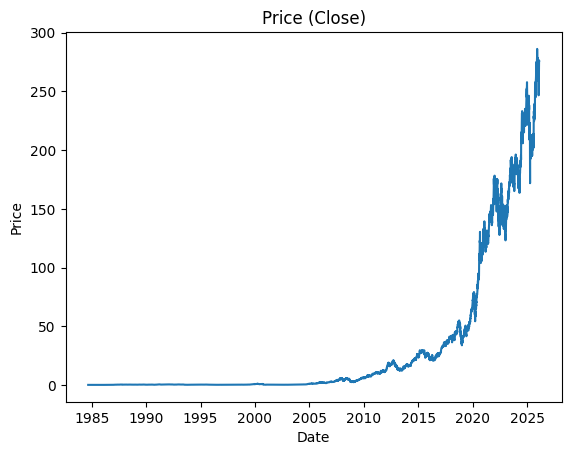

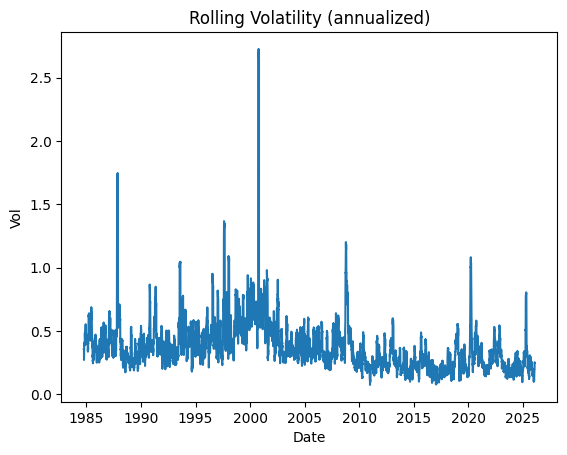

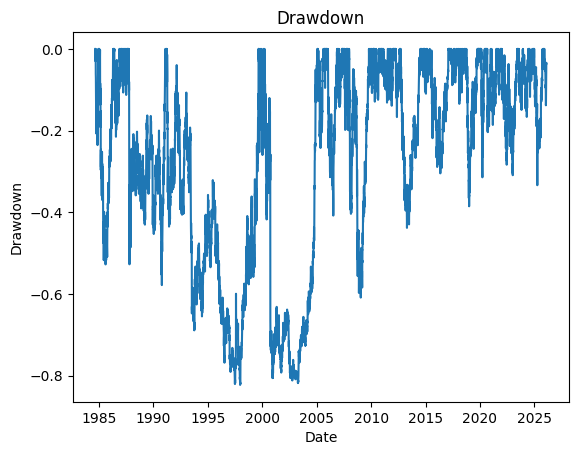

In [2]:
import csv
import io
import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import requests


def fetch_stooq_daily_close(symbol: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Fetch daily OHLCV from Stooq and return (dates, close_prices).
    - dates: np.ndarray dtype='datetime64[D]'
    - close_prices: np.ndarray dtype=float
    Example symbols:
      - 'aapl.us', 'msft.us', 'tsla.us'
      - 'xauusd' (gold), 'eurusd' (forex)
    """
    url = f"https://stooq.com/q/d/l/?s={symbol.lower()}&i=d"
    r = requests.get(url, timeout=20)
    r.raise_for_status()

    # Parse CSV
    f = io.StringIO(r.text)
    reader = csv.DictReader(f)
    dates = []
    closes = []

    for row in reader:
        # Stooq columns are usually: Date, Open, High, Low, Close, Volume
        d = row.get("Date")
        c = row.get("Close")
        if not d or not c:
            continue
        dates.append(d)
        closes.append(float(c))

    if len(closes) < 5:
        raise ValueError(
            f"Not enough data returned for symbol='{symbol}'. "
            f"Try another (e.g., 'aapl.us') or check spelling."
        )

    dates = np.array(dates, dtype="datetime64[D]")
    closes = np.array(closes, dtype=float)

    # Stooq often returns newest -> oldest; ensure oldest -> newest for time series math
    if dates[0] > dates[-1]:
        dates = dates[::-1]
        closes = closes[::-1]

    return dates, closes


# ----------------------------
# Risk metrics
# ----------------------------
def simple_returns(prices: np.ndarray) -> np.ndarray:
    """r_t = P_t / P_{t-1} - 1"""
    return prices[1:] / prices[:-1] - 1.0


def log_returns(prices: np.ndarray) -> np.ndarray:
    """lr_t = ln(P_t / P_{t-1})"""
    return np.log(prices[1:] / prices[:-1])


def equity_curve(returns: np.ndarray, start: float = 1.0) -> np.ndarray:
    """Equity curve from returns: start * cumprod(1 + r)"""
    return start * np.cumprod(1.0 + returns)


def rolling_volatility(returns: np.ndarray, window: int = 20, annualize: bool = True) -> np.ndarray:
    """
    Rolling standard deviation of returns.
    Returns an array of length len(returns) with NaN for the first (window-1) entries.
    """
    out = np.full_like(returns, np.nan, dtype=float)
    if len(returns) < window:
        return out

    # Use sliding windows (NumPy >= 1.20)
    windows = np.lib.stride_tricks.sliding_window_view(returns, window_shape=window)
    vol = windows.std(axis=1, ddof=1)  # sample std
    if annualize:
        vol *= math.sqrt(252)  # trading days/year

    out[window - 1 :] = vol
    return out


def drawdown_from_equity(eq: np.ndarray) -> np.ndarray:
    """Drawdown series: eq / running_max(eq) - 1"""
    running_max = np.maximum.accumulate(eq)
    return eq / running_max - 1.0


def max_drawdown(dd: np.ndarray) -> float:
    """Max drawdown is the minimum value of drawdown (most negative)."""
    return float(np.min(dd))


def max_drawdown_duration(dd: np.ndarray) -> int:
    """
    Longest consecutive number of days spent below 0 drawdown.
    (Simple and readable loop; fine for this project.)
    """
    best = 0
    cur = 0
    for x in dd:
        if x < 0:
            cur += 1
            best = max(best, cur)
        else:
            cur = 0
    return best


def worst_losses(returns: np.ndarray, dates_for_returns: np.ndarray, n: int = 5):
    """
    Return the worst n daily returns and corresponding dates.
    dates_for_returns should align with returns (i.e., dates[1:]).
    """
    idx = np.argsort(returns)[:n]  # most negative first
    return dates_for_returns[idx], returns[idx]


@dataclass
class Summary:
    symbol: str
    n_days: int
    total_return: float
    ann_vol_20d_latest: float
    max_dd: float
    max_dd_duration_days: int


def summarize(symbol: str, dates: np.ndarray, prices: np.ndarray, vol_window: int = 20) -> Summary:
    r = simple_returns(prices)
    eq = equity_curve(r, start=1.0)
    dd = drawdown_from_equity(eq)
    vol = rolling_volatility(log_returns(prices), window=vol_window, annualize=True)

    total_ret = float(eq[-1] - 1.0)
    latest_vol = float(vol[~np.isnan(vol)][-1]) if np.any(~np.isnan(vol)) else float("nan")

    return Summary(
        symbol=symbol,
        n_days=int(len(r)),
        total_return=total_ret,
        ann_vol_20d_latest=latest_vol,
        max_dd=max_drawdown(dd),
        max_dd_duration_days=max_drawdown_duration(dd),
    )


# ----------------------------
# Optional plotting
# ----------------------------
def plot_basic(dates: np.ndarray, prices: np.ndarray, vol: np.ndarray, dd: np.ndarray):
    import matplotlib.pyplot as plt

    # Align x-axes:
    # prices has len N with dates len N
    # returns/vol/dd use dates[1:] in many calculations; dd is based on equity which matches returns length
    d_ret = dates[1:]

    plt.figure()
    plt.plot(dates, prices)
    plt.title("Price (Close)")
    plt.xlabel("Date")
    plt.ylabel("Price")

    plt.figure()
    plt.plot(d_ret, vol)
    plt.title("Rolling Volatility (annualized)")
    plt.xlabel("Date")
    plt.ylabel("Vol")

    plt.figure()
    plt.plot(d_ret, dd)
    plt.title("Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Drawdown")

    plt.show()


def main():
    # Pick a symbol (examples: 'aapl.us', 'msft.us', 'tsla.us', 'xauusd')
    symbol = "aapl.us"
    vol_window = 20
    worst_n = 5
    do_plot = True  # set False if you want just numbers

    dates, prices = fetch_stooq_daily_close(symbol)

    # Core series
    r = simple_returns(prices)
    lr = log_returns(prices)
    eq = equity_curve(r)
    dd = drawdown_from_equity(eq)
    vol = rolling_volatility(lr, window=vol_window, annualize=True)

    # Summary
    s = summarize(symbol, dates, prices, vol_window=vol_window)

    # Worst losses
    loss_dates, loss_vals = worst_losses(r, dates[1:], n=worst_n)

    print("\n=== Risk Dashboard (Day 1) ===")
    print(f"Symbol: {s.symbol}")
    print(f"Observations (returns): {s.n_days}")
    print(f"Total return (period): {s.total_return:.2%}")
    print(f"Latest {vol_window}D ann. volatility (log returns): {s.ann_vol_20d_latest:.2%}")
    print(f"Max drawdown: {s.max_dd:.2%}")
    print(f"Max drawdown duration: {s.max_dd_duration_days} days")

    print(f"\nWorst {worst_n} daily returns:")
    for d, val in zip(loss_dates, loss_vals):
        print(f"  {str(d)} : {val:.2%}")

    if do_plot:
        plot_basic(dates, prices, vol, dd)


if __name__ == "__main__":
    main()



=== Risk Dashboard (Day 2) ===
Symbol: aapl.us
Data points (returns): 10434

VaR / CVaR (Historical):
  VaR 95%  : 3.85%
  CVaR 95% : 5.82%
  VaR 99%  : 6.73%
  CVaR 99% : 9.65%

VaR (Normal assumption) (optional comparison):
  Normal VaR 95% : 4.30%
  Normal VaR 99% : 6.12%

Rolling VaR backtest (window=252, confidence=99%):
  Usable days: 10183
  Breaches observed: 135
  Breaches expected (roughly): 101.8

Stress tests (impact on investment):
  Starting value for scenario calc: £10,000
  One-day shock: -5%                  -> £9,500 (-5.00%)
  One-day shock: -10%                 -> £9,000 (-10.00%)
  3 bad days in a row: -3%, -2%, -2%  -> £9,316 (-6.84%)
  5-day slide: -2% each day           -> £9,039 (-9.61%)


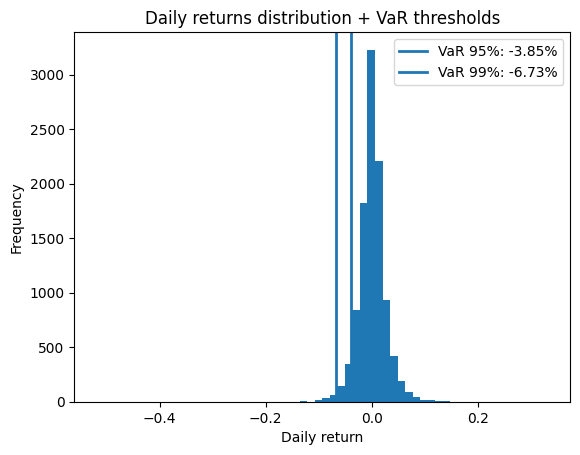

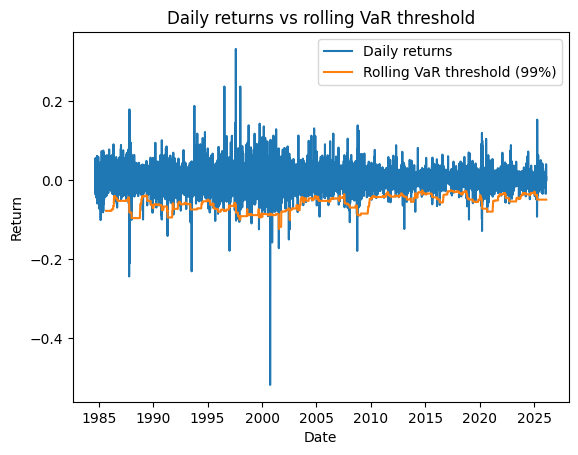

In [1]:
import csv
import io
import math
from statistics import NormalDist
from typing import Dict, List, Tuple

import numpy as np
import requests


# ----------------------------
# Data fetching (Stooq CSV)
# ----------------------------
def fetch_stooq_daily_close(symbol: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Fetch daily close prices from Stooq (no API key).
    Returns:
      dates: np.ndarray dtype='datetime64[D]'
      closes: np.ndarray dtype=float
    Example symbols: 'aapl.us', 'msft.us', 'tsla.us', 'xauusd', 'eurusd'
    """
    url = f"https://stooq.com/q/d/l/?s={symbol.lower()}&i=d"
    r = requests.get(url, timeout=20)
    r.raise_for_status()

    f = io.StringIO(r.text)
    reader = csv.DictReader(f)
    dates, closes = [], []

    for row in reader:
        d = row.get("Date")
        c = row.get("Close")
        if not d or not c:
            continue
        dates.append(d)
        closes.append(float(c))

    if len(closes) < 20:
        raise ValueError(f"Not enough data for {symbol}. Try something like 'aapl.us'.")

    dates = np.array(dates, dtype="datetime64[D]")
    closes = np.array(closes, dtype=float)

    # Ensure chronological order (oldest -> newest)
    if dates[0] > dates[-1]:
        dates = dates[::-1]
        closes = closes[::-1]

    return dates, closes


# ----------------------------
# Core helpers
# ----------------------------
def simple_returns(prices: np.ndarray) -> np.ndarray:
    """r_t = P_t / P_{t-1} - 1"""
    return prices[1:] / prices[:-1] - 1.0


def equity_curve(returns: np.ndarray, start: float = 1.0) -> np.ndarray:
    """Equity curve from returns: start * cumprod(1 + r)"""
    return start * np.cumprod(1.0 + returns)


# ----------------------------
# VaR / CVaR (Historical + optional Normal)
# ----------------------------
def historical_var(returns: np.ndarray, confidence: float = 0.95) -> float:
    """
    Historical Value at Risk (VaR) as a POSITIVE loss number.
    Example: 0.03 means "3% loss VaR".
    """
    alpha = 1.0 - confidence
    q = np.quantile(returns, alpha)   # left-tail quantile (negative in bad times)
    return float(-q)


def historical_cvar(returns: np.ndarray, confidence: float = 0.95) -> float:
    """
    Historical CVaR (Expected Shortfall) as a POSITIVE loss number.
    Average loss given you're in the worst (1-confidence) fraction of days.
    """
    alpha = 1.0 - confidence
    q = np.quantile(returns, alpha)
    tail = returns[returns <= q]
    if len(tail) == 0:
        return float("nan")
    return float(-tail.mean())


def normal_var(returns: np.ndarray, confidence: float = 0.95) -> float:
    """
    Parametric VaR assuming returns ~ Normal(mu, sigma).
    Also returned as a POSITIVE loss number.
    """
    mu = float(np.mean(returns))
    sigma = float(np.std(returns, ddof=1))
    alpha = 1.0 - confidence
    z = NormalDist().inv_cdf(alpha)  # e.g., alpha=0.05 => z ~ -1.645
    q = mu + sigma * z
    return float(-q)


# ----------------------------
# Rolling VaR + backtest breaches
# ----------------------------
def rolling_historical_var(returns: np.ndarray, window: int = 252, confidence: float = 0.99) -> np.ndarray:
    """
    Rolling historical VaR series (positive loss number).
    Output length matches returns with NaN for first window-1 points.
    """
    out = np.full(len(returns), np.nan, dtype=float)
    if len(returns) < window:
        return out

    windows = np.lib.stride_tricks.sliding_window_view(returns, window_shape=window)
    alpha = 1.0 - confidence

    # quantile per window; returns shape: (n_windows, window)
    q = np.quantile(windows, alpha, axis=1)
    out[window - 1:] = -q
    return out


def count_var_breaches(returns: np.ndarray, var_series: np.ndarray) -> int:
    """
    A breach happens when actual return is worse than -VaR.
    (VaR is positive. Loss threshold is -VaR.)
    """
    mask = ~np.isnan(var_series)
    r = returns[mask]
    v = var_series[mask]
    breaches = np.sum(r < -v)
    return int(breaches)


# ----------------------------
# Stress tests (simple scenarios)
# ----------------------------
def apply_scenario(eq_last: float, scenario_returns: List[float]) -> float:
    """
    Apply a sequence of returns to the last equity value.
    scenario_returns are decimal returns, e.g., -0.05 for -5%.
    """
    value = eq_last
    for r in scenario_returns:
        value *= (1.0 + r)
    return float(value)


def build_simple_scenarios() -> Dict[str, List[float]]:
    """
    Beginner-friendly stress scenarios.
    """
    return {
        "One-day shock: -5%": [-0.05],
        "One-day shock: -10%": [-0.10],
        "3 bad days in a row: -3%, -2%, -2%": [-0.03, -0.02, -0.02],
        "5-day slide: -2% each day": [-0.02, -0.02, -0.02, -0.02, -0.02],
    }


# ----------------------------
# Optional plots
# ----------------------------
def plot_return_histogram_with_var(returns: np.ndarray, vars_to_plot: Dict[str, float]):
    import matplotlib.pyplot as plt

    plt.figure()
    plt.hist(returns, bins=60)
    for label, v in vars_to_plot.items():
        # VaR is positive loss. Threshold return is -VaR.
        plt.axvline(-v, linewidth=2, label=f"{label}: {-v:.2%}")
    plt.title("Daily returns distribution + VaR thresholds")
    plt.xlabel("Daily return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


def plot_rolling_var(dates_returns: np.ndarray, returns: np.ndarray, var_series: np.ndarray, confidence: float):
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(dates_returns, returns, label="Daily returns")
    plt.plot(dates_returns, -var_series, label=f"Rolling VaR threshold ({int(confidence*100)}%)")
    plt.title("Daily returns vs rolling VaR threshold")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.show()


# ----------------------------
# Main
# ----------------------------
def main():
    symbol = "aapl.us"

    # Risk settings
    conf_levels = [0.95, 0.99]
    rolling_window = 252      # ~1 trading year
    rolling_conf = 0.99
    initial_investment = 10_000

    do_plots = True

    dates, prices = fetch_stooq_daily_close(symbol)
    r = simple_returns(prices)          # daily close-to-close returns
    dates_r = dates[1:]                 # aligns with returns

    eq = equity_curve(r, start=1.0)
    eq_last = float(eq[-1])

    print("\n=== Risk Dashboard (Day 2) ===")
    print(f"Symbol: {symbol}")
    print(f"Data points (returns): {len(r)}")

    # VaR / CVaR (historical + optional normal VaR)
    print("\nVaR / CVaR (Historical):")
    hist_vars = {}
    for c in conf_levels:
        var_c = historical_var(r, confidence=c)
        cvar_c = historical_cvar(r, confidence=c)
        hist_vars[f"VaR {int(c*100)}%"] = var_c

        print(f"  VaR {int(c*100)}%  : {var_c:.2%}")
        print(f"  CVaR {int(c*100)}% : {cvar_c:.2%}")

    print("\nVaR (Normal assumption) (optional comparison):")
    for c in conf_levels:
        nv = normal_var(r, confidence=c)
        print(f"  Normal VaR {int(c*100)}% : {nv:.2%}")

    # Rolling VaR + breaches
    var_roll = rolling_historical_var(r, window=rolling_window, confidence=rolling_conf)
    breaches = count_var_breaches(r, var_roll)

    usable_days = int(np.sum(~np.isnan(var_roll)))
    expected_breaches = usable_days * (1.0 - rolling_conf)

    print(f"\nRolling VaR backtest (window={rolling_window}, confidence={int(rolling_conf*100)}%):")
    print(f"  Usable days: {usable_days}")
    print(f"  Breaches observed: {breaches}")
    print(f"  Breaches expected (roughly): {expected_breaches:.1f}")

    # Stress tests
    scenarios = build_simple_scenarios()
    print("\nStress tests (impact on investment):")
    print(f"  Starting value for scenario calc: £{initial_investment:,.0f}")
    for name, scen in scenarios.items():
        # Apply to an investment starting today (not the whole history)
        stressed = apply_scenario(initial_investment, scen)
        loss_pct = (stressed / initial_investment) - 1.0
        print(f"  {name:<35} -> £{stressed:,.0f} ({loss_pct:.2%})")

    if do_plots:
        # Histogram with VaR lines
        plot_return_histogram_with_var(r, hist_vars)

        # Rolling VaR threshold vs returns
        plot_rolling_var(dates_r, r, var_roll, confidence=rolling_conf)


if __name__ == "__main__":
    main()
